## **Basic Features**

**Purpose:** Engineer basic microstructure features from cleaned data

**What it does:**
- Loads cleaned data from `data/interim/`
- Computes fundamental LOB features
- Creates simple derived variables
- Saves engineered features to `data/processed/`

**Output:**
- Feature dataset in `data/processed/`
- Feature visualizations
- Correlation analysis
- Feature statistics


## Basic Features
*Foundational measures that are straightforward to compute and interpret*
1. 🟢 **Spread** - Simple price difference
2. 🟢 **Mid Price** - Average of best bid/ask
3. 🟢 **Relative Spread** - Normalized spread
4. 🟢 **Returns (Multiple Lags)** - Log price changes
5. 🟢 **Queue Depth (Top 1, Top 5, Cumulative)** - Raw quantities at levels
6. 🟢 **Spread at Multiple Levels** - Price differences at each level
7. 🟢 **Average Spread (Top N Levels)** - Mean of spreads
8. 🟢 **Intraday Patterns (Hour, Minute)** - Time-of-day indicators

## Intermediate Features
*Require some statistical/financial understanding but still conceptually accessible*

9. 🟢 **Weighted Mid Price (Microprice)** - Volume-weighted midpoint/fair value
10. 🟢 **Rolling Volatility** - Standard deviation of returns
11. 🟢 **VWAP** - Volume-weighted average price
12. 🟢 **Effective Spread** - VWAP difference
13. 🟢 **Depth Imbalance** - Normalized bid/ask difference
14. 🟢 **Basic Depth** - Total volume on bid and ask sides separately
15. 🟢 **Total Depth** - Sum of all bid and ask volumes
16. 🟢 **Depth Ratio** - Ratio of bid depth to ask depth
17. 🟢 **Average Volume Per Level** - Mean quantity across levels
18. 🟢 **Queue Imbalance (Multiple Levels)** - Depth imbalance at specific levels
19. 🟢 **Cumulative Volume Imbalance** - Absolute quantity difference
20. 🟢 **Order Book Thickness** - Average quantity per level
21. 🟢 **Depth Concentration** - Fraction of liquidity at top
22. 🟢 **Time Since Event** - Temporal gap measurement

In [1]:
# ============================================================================
# 10_basic_features.ipynb
# Engineer basic microstructure features from cleaned LOB data
# ============================================================================

# %% Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# %% Project imports (assuming you ran `pip install -e .`)
from src.config import (
    INTERIM_DATA_DIR, 
    PROCESSED_DATA_DIR,
    FIGURES_DIR
)
from src.data.lob_loader import LOBLoader



## Raw Data Import

In [2]:
# ============================================================================
# 10_basic_features.ipynb
# Purpose: Engineer basic microstructure features from cleaned data
# ============================================================================

# %% Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
from pathlib import Path


# Visualization settings
plt.style.use('seaborn-v0_8-paper')  
plt.rcParams.update({
    'font.family': 'serif',
    'font.weight': 'bold',        
    'axes.labelweight': 'bold',    
    'axes.titleweight': 'bold',   
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
})
%matplotlib inline


from src.config import RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, FIGURES_DIR, TABLES_DIR


In [3]:
# Configuration
SYMBOL = "BTCUSDT"
INPUT_FILE = INTERIM_DATA_DIR / f"{SYMBOL}_lob_cleaned.parquet"
OUTPUT_FILE = PROCESSED_DATA_DIR / f"{SYMBOL}_basic_parquet.csv"

# Create output directories if needed
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
TABLES_DIR.mkdir(parents=True, exist_ok=True)

print(f"Input: {INPUT_FILE}")
print(f"Output: {OUTPUT_FILE}")

Input: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/data/interim/BTCUSDT_lob_cleaned.parquet
Output: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/data/processed/BTCUSDT_basic_parquet.csv


In [4]:
# Load cleaned data
print("Loading cleaned LOB data...")
lob_df = pd.read_parquet(INPUT_FILE)

print(f"Loaded {len(lob_df):,} snapshots")
print(f"Date range: {lob_df['timestamp'].min()} to {lob_df['timestamp'].max()}")
print(f"\nColumns: {lob_df.columns.tolist()}")
lob_df.head()

Loading cleaned LOB data...
Loaded 132,214 snapshots
Date range: 2025-10-12 22:38:17+00:00 to 2025-10-14 15:43:45+00:00

Columns: ['timestamp', 'bid_price_1', 'bid_volume_1', 'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3', 'bid_price_4', 'bid_volume_4', 'bid_price_5', 'bid_volume_5', 'bid_price_6', 'bid_volume_6', 'bid_price_7', 'bid_volume_7', 'bid_price_8', 'bid_volume_8', 'bid_price_9', 'bid_volume_9', 'bid_price_10', 'bid_volume_10', 'ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2', 'ask_price_3', 'ask_volume_3', 'ask_price_4', 'ask_volume_4', 'ask_price_5', 'ask_volume_5', 'ask_price_6', 'ask_volume_6', 'ask_price_7', 'ask_volume_7', 'ask_price_8', 'ask_volume_8', 'ask_price_9', 'ask_volume_9', 'ask_price_10', 'ask_volume_10']


,timestamp,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,bid_price_4,bid_volume_4,bid_price_5,...,ask_price_6,ask_volume_6,ask_price_7,ask_volume_7,ask_price_8,ask_volume_8,ask_price_9,ask_volume_9,ask_price_10,ask_volume_10
0,2025-10-12 22:38:17+00:00,115036.24,0.06461,115036.23,0.00848,115036.21,0.07180,115036.20,0.00019,115036.16,...,115533.65,0.25438,115536.63,0.06505,115666.18,0.00115,115685.41,0.00006,115687.03,0.00028
1,2025-10-12 22:38:18+00:00,115036.24,0.06461,115036.23,0.00848,115036.21,0.07180,115036.20,0.00019,115036.16,...,115533.65,0.25438,115536.63,0.06505,115666.18,0.00115,115685.41,0.00006,115687.03,0.00028
2,2025-10-12 22:38:19+00:00,115036.27,1.33173,115036.26,0.07180,115036.24,0.06461,115036.23,0.00848,115036.20,...,115532.66,0.01134,115533.65,0.25438,115536.63,0.06505,115596.47,0.00010,115666.18,0.00115
3,2025-10-12 22:38:20+00:00,115036.27,1.43183,115036.26,0.07180,115036.24,0.06461,115036.20,0.00019,115036.16,...,115532.66,0.01134,115533.65,0.25438,115536.63,0.06505,115596.47,0.00010,115666.18,0.00115
4,2025-10-12 22:38:21+00:00,115036.29,1.43183,115036.26,0.07180,115036.24,0.06461,115036.20,0.00019,115036.16,...,115532.66,0.01134,115533.65,0.25438,115536.63,0.06505,115596.47,0.00010,115666.18,0.00115


## Create Basic Features

In [5]:
# Compute basic features using imported functions

print("\n=== Computing Basic Features ===\n")

# create basic_featured dataframe with timestamps 
basic_features = pd.DataFrame(index=lob_df.index)
basic_features['timestamp'] = lob_df['timestamp']

###################################################
# mid price features
###################################################

from src.features.basic_features import (
    compute_mid_price,
    compute_weighted_mid
)

print("Computing mid-price....")
basic_features['mid_price'] = compute_mid_price(
    bid_price=lob_df['bid_price_1'],
    ask_price=lob_df['ask_price_1']
)

print("Computing weighted mid-price (micro price)....")
basic_features['weighted_mid'] = compute_weighted_mid(
    bid_price=lob_df['bid_price_1'],
    ask_price=lob_df['ask_price_1'],
    bid_volume=lob_df['bid_volume_1'],
    ask_volume=lob_df['ask_volume_1']
)


print(f"\nAdded mid price features. Total columns: {len(basic_features.columns)}\n")


###################################################
# spread features
###################################################

from src.features.basic_features import (
    compute_spread,
    compute_average_spread,
    compute_spreads_all_levels
)

print("Computing spread....")
spread_features = compute_spread(
    bid_price=lob_df['bid_price_1'],
    ask_price=lob_df['ask_price_1'],
    mid_price=basic_features['mid_price']
)
basic_features['spread_abs'] = spread_features['spread_abs']
basic_features['spread_bps'] = spread_features['spread_bps']


print("Computing average spread....")
num_levels = 10
basic_features['average_spread'] = compute_average_spread(
    bid_prices=lob_df[[f'bid_price_{i}' for i in range(1, num_levels+1)]],
    ask_prices=lob_df[[f'ask_price_{i}' for i in range(1, num_levels+1)]],
    n_levels=num_levels
)

print("Computing all spreads at once....")
spread_features = compute_spreads_all_levels(
    bid_prices=lob_df,
    ask_prices=lob_df,
    n_levels=10
)

# Add all spread features to main dataframe
basic_features = pd.concat([basic_features, spread_features], axis=1)

print(f"\nAdded spread features. Total columns: {len(basic_features.columns)}\n")


###################################################
# returns features
###################################################

from src.features.basic_features import (
    compute_log_returns_multiple_lags
)

print("Compute multiple lags at once....")
return_lags = [1, 2, 3, 5, 10, 20, 30, 60]
return_features = compute_log_returns_multiple_lags(
    prices=basic_features['mid_price'],
    lags=return_lags
)

basic_features = pd.concat([basic_features, return_features], axis=1)

print(f"\nAdded returns features. Total columns: {len(basic_features.columns)}\n")

###################################################
# flow imbalance features
###################################################

from src.features.basic_features import (
    compute_imbalance,
    compute_multi_level_imbalance,
    compute_volume_weighted_imbalance
)

print("Computing Top-of-book imbalance....")
basic_features['imbalance_top'] = compute_imbalance(
    lob_df['bid_volume_1'],
    lob_df['ask_volume_1']
)

print("Computing 5-level imbalance....")
basic_features['imbalance_5level'] = compute_multi_level_imbalance(lob_df, levels=5)

print("Computing 10-level imbalance....")
basic_features['imbalance_10level'] = compute_multi_level_imbalance(lob_df, levels=10)

print("Weighted imbalance (exponential decay)....")
basic_features['imbalance_weighted'] = compute_volume_weighted_imbalance(
    lob_df, 
    levels=5, 
    decay_factor=0.8
)

print("Computing Alternative: log-ratio imbalance (for some models this works better)....")
basic_features['imbalance_log'] = compute_imbalance(
    lob_df['bid_volume_1'],
    lob_df['ask_volume_1'],
    method='log_ratio'
)
print(f"\nAdded imbalance features. Total columns: {len(lob_df.columns)}\n")


####################################################################
# Depth Imbalance features (Liquidity Imbalance at Multiple Depths)
#####################################################################

from src.features.basic_features import (
    compute_depth,
    compute_total_depth,
    compute_depth_imbalance,
    compute_depth_ratio,
    compute_avg_volume_per_level
)

print("Computing Basic depth....")
depth_features = compute_depth(lob_df, levels=[1, 5, 10]) # Top 1, top 5, top 10 levels
basic_features = pd.concat([basic_features, depth_features], axis=1)

print("Computing Total depth....")
total_depth = compute_total_depth(lob_df, levels=[5, 10])
basic_features = pd.concat([basic_features, total_depth], axis=1)

print("Computing Depth imbalance....")
depth_imb = compute_depth_imbalance(lob_df, levels=[5, 10])
basic_features = pd.concat([basic_features, depth_imb], axis=1)

print("Computing Depth ratio....")
depth_ratio = compute_depth_ratio(basic_features, levels=[5, 10])
basic_features = pd.concat([basic_features, depth_ratio], axis=1)

print("Computing Average volume per level....")
avg_vol = compute_avg_volume_per_level(lob_df, levels=[5, 10])
basic_features = pd.concat([basic_features, avg_vol], axis=1)

print(f"\nAdded depth features. Total columns: {len(basic_features.columns)}\n")

####################################################################
# Queue Depth Features 
#####################################################################

from src.features.basic_features import (
    compute_queue_depth_top_n,
    compute_cumulative_queue_depth
)


print("Computing Top 5 levels on both sides ...")
top5_depth = compute_queue_depth_top_n(
    bid_volumes=lob_df,
    ask_volumes=lob_df,
    n=5
)
basic_features = pd.concat([basic_features, top5_depth], axis=1)

print("Cumulative depth (total liquidity measure) ...")
cumulative_depth = compute_cumulative_queue_depth(
    bid_volumes=lob_df,
    ask_volumes=lob_df,
    n_levels=10
)

basic_features = pd.concat([basic_features, cumulative_depth], axis=1)


print(f"\nAdded queue depth features. Total columns: {len(basic_features.columns)}\n")


####################################################################
# Volatility Features 
#####################################################################


from src.features.basic_features import (
    compute_rolling_volatility,
    compute_rolling_volatility_multiple_windows,
    compute_realized_volatility
)

# Ensure you have returns computed
if 'log_return_lag_1' not in basic_features.columns:
    basic_features['log_return_lag_1'] = compute_log_return(lob_df['mid_price'], lag=1)

print("\n=== Computing Rolling Volatility Features ===\n")

# Option 1: Single window
basic_features['rolling_vol_20'] = compute_rolling_volatility(
    returns=basic_features['log_return_lag_1'],
    window=20
)

# Option 2: Multiple windows (recommended for ML)
vol_windows = [10, 20, 60, 100]
vol_features = compute_rolling_volatility_multiple_windows(
    returns=basic_features['log_return_lag_1'],
    windows=vol_windows
)
basic_features = pd.concat([basic_features, vol_features], axis=1)

# Option 3: Realized volatility (alternative estimator)
basic_features['realized_vol_20'] = compute_realized_volatility(
    returns=basic_features['log_return_lag_1'],
    window=20
)

# Option 4: Annualized volatility (for comparison to annual benchmarks)
# For minute data: 252 trading days × 390 minutes per day = 98,280 periods/year
basic_features['rolling_vol_20_annual'] = compute_rolling_volatility(
    returns=basic_features['log_return_lag_1'],
    window=20,
    annualize=True,
    trading_periods_per_year=252 * 390
)

print(f"Added volatility features. Total columns: {len(basic_features.columns)}\n")


####################################################################
# VWAP Features
#####################################################################

from src.features.basic_features import (
    compute_vwap,
    compute_vwap_multiple_windows,
    compute_vwap_deviation
)

print("\n=== Computing VWAP Features ===\n")

# For VWAP, we need price and volume
# Option 1: Use mid_price and bid_volume_1 (or total volume at top level)
basic_features['top_volume'] = lob_df['bid_volume_1'] + lob_df['ask_volume_1']

# Option 2: Daily VWAP (resets at market open each day)
# Note: This requires timestamp to be set as DatetimeIndex
if 'timestamp' in basic_features.columns:
    basic_features_indexed = basic_features.set_index('timestamp')
    basic_features['vwap_daily'] = compute_vwap(
        prices=basic_features_indexed['mid_price'],
        volumes=basic_features_indexed['top_volume'],
        window=None,
        reset_daily=True
    ).values

# Option 3: Rolling VWAP (recommended for ML features)
vwap_windows = [20, 60, 100]
vwap_features = compute_vwap_multiple_windows(
    prices=basic_features['mid_price'],
    volumes=basic_features['top_volume'],
    windows=vwap_windows
)
basic_features = pd.concat([basic_features, vwap_features], axis=1)

# Option 4: VWAP deviation (distance from fair value)
basic_features['vwap_dev_abs'] = compute_vwap_deviation(
    prices=basic_features['mid_price'],
    vwap=basic_features['vwap_rolling_60'],
    method='absolute'
)

basic_features['vwap_dev_pct'] = compute_vwap_deviation(
    prices=basic_features['mid_price'],
    vwap=basic_features['vwap_rolling_60'],
    method='relative'
)

basic_features['vwap_dev_bps'] = compute_vwap_deviation(
    prices=basic_features['mid_price'],
    vwap=basic_features['vwap_rolling_60'],
    method='bps'
)

print(f"Added VWAP features. Total columns: {len(basic_features.columns)}\n")




####################################################################
# Queue Imbalance Features
#####################################################################


from src.features.basic_features import (
    compute_queue_imbalance_at_level,
    compute_queue_imbalance_multiple_levels,
    compute_queue_imbalance_gradient,
    compute_queue_imbalance_volatility
)

print("\n=== Computing Queue Imbalance Features ===\n")

# Option 1: Single level imbalance
basic_features['queue_imb_level_1'] = compute_queue_imbalance_at_level(
    bid_volumes=lob_df,
    ask_volumes=lob_df,
    level=1
)

# Option 2: Multiple levels (recommended for ML)
imbalance_levels = [1, 2, 3, 5, 10]
queue_imb_features = compute_queue_imbalance_multiple_levels(
    bid_volumes=lob_df,
    ask_volumes=lob_df,
    levels=imbalance_levels
)
basic_features = pd.concat([basic_features, queue_imb_features], axis=1)

# Option 3: Imbalance gradient (near vs far book dynamics)
basic_features['queue_imb_gradient_1_10'] = compute_queue_imbalance_gradient(
    bid_volumes=lob_df,
    ask_volumes=lob_df,
    level_near=1,
    level_far=10
)

basic_features['queue_imb_gradient_1_5'] = compute_queue_imbalance_gradient(
    bid_volumes=lob_df,
    ask_volumes=lob_df,
    level_near=1,
    level_far=5
)

# Option 4: Imbalance volatility (stability measure)
basic_features['queue_imb_vol_level_1'] = compute_queue_imbalance_volatility(
    bid_volumes=lob_df,
    ask_volumes=lob_df,
    level=1,
    window=20
)

print(f"Added queue imbalance features. Total columns: {len(basic_features.columns)}\n")




####################################################################
# Cumulative Volume Imbalance Features
#####################################################################

from src.features.basic_features import (
    compute_cumulative_volume_imbalance,
    compute_cumulative_volume_imbalance_rolling,
    compute_cumulative_volume_imbalance_multiple_windows,
    compute_cumulative_volume_imbalance_acceleration
)

print("\n=== Computing Cumulative Volume Imbalance Features ===\n")

# Option 1: Instantaneous cumulative imbalance (absolute quantities)
basic_features['cumulative_vol_imb'] = compute_cumulative_volume_imbalance(
    bid_volumes=lob_df,
    ask_volumes=lob_df,
    levels=10,
    normalize=False
)

# Option 2: Normalized version (for comparison across time/assets)
basic_features['cumulative_vol_imb_norm'] = compute_cumulative_volume_imbalance(
    bid_volumes=lob_df,
    ask_volumes=lob_df,
    levels=10,
    normalize=True
)

# Option 3: Rolling average (smooth out noise)
basic_features['cumulative_vol_imb_rolling_20'] = compute_cumulative_volume_imbalance_rolling(
    bid_volumes=lob_df,
    ask_volumes=lob_df,
    levels=10,
    window=20,
    normalize=False
)

# Option 4: Multiple windows (multi-timeframe analysis)
imb_windows = [10, 30, 60]
cumulative_imb_features = compute_cumulative_volume_imbalance_multiple_windows(
    bid_volumes=lob_df,
    ask_volumes=lob_df,
    levels=10,
    windows=imb_windows,
    normalize=False
)
basic_features = pd.concat([basic_features, cumulative_imb_features], axis=1)

# Option 5: Imbalance acceleration (momentum of pressure)
basic_features['cumulative_vol_imb_accel'] = compute_cumulative_volume_imbalance_acceleration(
    bid_volumes=lob_df,
    ask_volumes=lob_df,
    levels=10,
    window=20
)

print(f"Added cumulative volume imbalance features. Total columns: {len(basic_features.columns)}\n")


####################################################################
# Order Book Thickness Features
#####################################################################

from src.features.basic_features import (
    compute_order_book_thickness,
    compute_order_book_thickness_ratio,
    compute_order_book_thickness_volatility,
    compute_order_book_thickness_change
)

print("\n=== Computing Order Book Thickness Features ===\n")

# Option 1: Overall thickness (both sides)
basic_features['thickness'] = compute_order_book_thickness(
    bid_volumes=lob_df,
    ask_volumes=lob_df,
    levels=10,
    side='both'
)

# Option 2: Separate bid and ask thickness
basic_features['thickness_bid'] = compute_order_book_thickness(
    bid_volumes=lob_df,
    ask_volumes=lob_df,
    levels=10,
    side='bid'
)

basic_features['thickness_ask'] = compute_order_book_thickness(
    bid_volumes=lob_df,
    ask_volumes=lob_df,
    levels=10,
    side='ask'
)

# Option 3: Thickness ratio (bid/ask asymmetry)
basic_features['thickness_ratio'] = compute_order_book_thickness_ratio(
    bid_volumes=lob_df,
    ask_volumes=lob_df,
    levels=10
)

# Option 4: Thickness volatility (stability measure)
basic_features['thickness_volatility'] = compute_order_book_thickness_volatility(
    bid_volumes=lob_df,
    ask_volumes=lob_df,
    levels=10,
    window=20,
    side='both'
)

# Option 5: Thickness change (building vs depleting)
basic_features['thickness_change_10'] = compute_order_book_thickness_change(
    bid_volumes=lob_df,
    ask_volumes=lob_df,
    levels=10,
    lag=10,
    side='both'
)

basic_features['thickness_change_30'] = compute_order_book_thickness_change(
    bid_volumes=lob_df,
    ask_volumes=lob_df,
    levels=10,
    lag=30,
    side='both'
)

print(f"Added order book thickness features. Total columns: {len(basic_features.columns)}\n")


####################################################################
# Depth Concentration Features
#####################################################################

from src.features.basic_features import (
    compute_depth_concentration_at_top,
    compute_depth_concentration_multiple_tops,
    compute_depth_concentration_asymmetry,
    compute_depth_concentration_change
)

print("\n=== Computing Depth Concentration Features ===\n")

# Option 1: Top-of-book concentration (most common)
basic_features['depth_conc_top_1'] = compute_depth_concentration_at_top(
    bid_volumes=lob_df,
    ask_volumes=lob_df,
    top_levels=1,
    total_levels=10,
    side='both'
)

# Option 2: Multiple top-level configurations
top_configs = [1, 3, 5]
concentration_features = compute_depth_concentration_multiple_tops(
    bid_volumes=lob_df,
    ask_volumes=lob_df,
    top_levels_list=top_configs,
    total_levels=10,
    side='both'
)
basic_features = pd.concat([basic_features, concentration_features], axis=1)

# Option 3: Separate bid and ask concentration
basic_features['depth_conc_bid'] = compute_depth_concentration_at_top(
    bid_volumes=lob_df,
    ask_volumes=lob_df,
    top_levels=1,
    total_levels=10,
    side='bid'
)

basic_features['depth_conc_ask'] = compute_depth_concentration_at_top(
    bid_volumes=lob_df,
    ask_volumes=lob_df,
    top_levels=1,
    total_levels=10,
    side='ask'
)

# Option 4: Concentration asymmetry (bid vs ask strategy difference)
basic_features['depth_conc_asymmetry'] = compute_depth_concentration_asymmetry(
    bid_volumes=lob_df,
    ask_volumes=lob_df,
    top_levels=1,
    total_levels=10
)

# Option 5: Concentration change (structure shifts)
basic_features['depth_conc_change_20'] = compute_depth_concentration_change(
    bid_volumes=lob_df,
    ask_volumes=lob_df,
    top_levels=1,
    total_levels=10,
    lag=20,
    side='both'
)

# Derived feature: Concentration gradient (how fast concentration increases with depth)
basic_features['depth_conc_gradient'] = (
    basic_features['depth_concentration_top_5'] - basic_features['depth_concentration_top_1']
)

print(f"Added depth concentration features. Total columns: {len(basic_features.columns)}\n")


####################################################################
# Time Features 
#####################################################################

from src.features.basic_features import (
    compute_intraday_time_features,
    compute_trading_session_features,
    compute_time_since_last_trade,
    compute_time_since_price_change,
    compute_time_since_volume_spike,
    compute_arrival_rate
)



print("\n=== Computing Time Since Event Features ===\n")

# Ensure timestamp column is datetime
if 'timestamp' not in basic_features.columns:
    raise ValueError("Need 'timestamp' column in dataframe")

basic_features['timestamp'] = pd.to_datetime(basic_features['timestamp'])

# Option 1: Time since last event (inter-arrival time)
basic_features['time_since_last_event'] = compute_time_since_last_trade(
    timestamps=basic_features['timestamp'],
    unit='seconds'
)

# Also in milliseconds for HFT analysis
basic_features['time_since_last_event_ms'] = compute_time_since_last_trade(
    timestamps=basic_features['timestamp'],
    unit='milliseconds'
)

# Option 2: Time since price change (consolidation detector)
basic_features['time_since_price_change'] = compute_time_since_price_change(
    prices=basic_features['mid_price'],
    timestamps=basic_features['timestamp'],
    threshold=0.0,  # Any change
    unit='seconds'
)

# Option 3: Time since volume spike (unusual activity detector)
basic_features['top_volume'] = lob_df['bid_volume_1'] + lob_df['ask_volume_1']
basic_features['time_since_volume_spike'] = compute_time_since_volume_spike(
    volumes=basic_features['top_volume'],
    timestamps=basic_features['timestamp'],
    spike_threshold=2.0,  # 2x average
    window=20,
    unit='seconds'
)

# Option 4: Arrival rate (market activity intensity)
basic_features['arrival_rate'] = compute_arrival_rate(
    timestamps=basic_features['timestamp'],
    window=20,
    unit='per_second'
)

print(f"Added time since event features. Total columns: {len(basic_features.columns)}\n")


print("Computing basic intraday time features....")
time_features = compute_intraday_time_features(
    timestamps=basic_features['timestamp'],
    include_cyclical=True
)
basic_features = pd.concat([basic_features, time_features], axis=1)

print("Computing trading session features....")
session_features = compute_trading_session_features(
    timestamps=basic_features['timestamp'],
    market_open='09:30:00',
    market_close='16:00:00'
)
basic_features = pd.concat([basic_features, session_features], axis=1)


print(f"\nAdded time features. Total columns: {len(basic_features.columns)}\n")

####################################################################
# End of Features 
#####################################################################

#  Use convenience function (recommended for production)
# lob_df = compute_all_basic_features(lob_df)

print("\n=== Feature engineering complete! ===\n")





=== Computing Basic Features ===

Computing mid-price....
Computing weighted mid-price (micro price)....

Added mid price features. Total columns: 3

Computing spread....
Computing average spread....
Computing all spreads at once....

Added spread features. Total columns: 16

Compute multiple lags at once....

Added returns features. Total columns: 24

Computing Top-of-book imbalance....
Computing 5-level imbalance....
Computing 10-level imbalance....
Weighted imbalance (exponential decay)....
Computing Alternative: log-ratio imbalance (for some models this works better)....

Added imbalance features. Total columns: 41

Computing Basic depth....
Computing Total depth....
Computing Depth imbalance....
Computing Depth ratio....
Computing Average volume per level....

Added depth features. Total columns: 41

Computing Top 5 levels on both sides ...
Cumulative depth (total liquidity measure) ...

Added queue depth features. Total columns: 54


=== Computing Rolling Volatility Features ===

## Feature Summary

In [6]:

from src.features.basic_features import (
    compute_summary_stats, 
    print_feature_summary,
    get_feature_columns
)


# Analyze ALL engineered features (recommended)
print("\n=== COMPLETE FEATURE ANALYSIS ===")
summary_stats = print_feature_summary(
    basic_features,
    exclude_raw_lob=True,  # Excludes bid_price_*, ask_price_*, etc.
    save_path= TABLES_DIR / 'all_features_summary.csv'
)




=== COMPLETE FEATURE ANALYSIS ===

📊 Analyzing 109 features...

FEATURE SUMMARY STATISTICS

Dataset: 132,214 observations
Features: 109 columns

--------------------------------------------------------------------------------
DATA QUALITY OVERVIEW
--------------------------------------------------------------------------------
                      count  missing  missing_pct  n_zeros  n_infinite  n_outliers  outlier_pct
mid_price          132214.0      0.0     0.000000      0.0         0.0         0.0     0.000000
weighted_mid       132214.0      0.0     0.000000      0.0         0.0         0.0     0.000000
spread_abs         132214.0      0.0     0.000000      0.0         0.0      4925.0     3.725022
spread_bps         132214.0      0.0     0.000000      0.0         0.0      4536.0     3.430802
average_spread     132214.0      0.0     0.000000      0.0         0.0      4053.0     3.065485
spread_level_1     132214.0      0.0     0.000000      0.0         0.0      4925.0     3.72502

In [7]:
# Analyze specific feature groups
feature_groups = get_feature_columns(basic_features)

print("\n=== SPREAD FEATURES ===")
spread_summary = print_feature_summary(
    basic_features,
    feature_cols=feature_groups['spread'],
    save_path= TABLES_DIR / 'spread_features_summary.csv'
)

print("\n=== IMBALANCE FEATURES ===")
imbalance_summary = print_feature_summary(
    basic_features,
    feature_cols=feature_groups['imbalance'],
    save_path= TABLES_DIR / 'imbalance_features_summary.csv'
)

print("\n=== DEPTH FEATURES ===")
depth_summary = print_feature_summary(
    basic_features,
    feature_cols=feature_groups['depth'],
    save_path= TABLES_DIR /  'depth_features_summary.csv'
)

print("\n=== RETURN FEATURES ===")
return_summary = print_feature_summary(
    basic_features,
    feature_cols=feature_groups['returns'],
    save_path= TABLES_DIR / 'return_features_summary.csv'
)

print("\n=== PRICE FEATURES ===")
price_summary = print_feature_summary(
    basic_features,
    feature_cols=feature_groups['price'],
    save_path= TABLES_DIR / 'price_features_summary.csv'
)


print(f"\n=== Time FEATURES ===")
time_summary = print_feature_summary(
    basic_features,
    feature_cols=feature_groups['time'],
    save_path= TABLES_DIR / 'time_features_summary.csv'
)

print("\n=== VOLATILITY FEATURES ===")
volatility_summary = print_feature_summary(
    basic_features,
    feature_cols=feature_groups['volatility'],
    save_path= TABLES_DIR / 'volatility_features_summary.csv'
)
# print("\n=== VWAP FEATURES ===")
# vwap_summary = print_feature_summary(
#     basic_features,
#     feature_cols=feature_groups['vwap'],
#     save_path= TABLES_DIR / 'vwap_features_summary.csv'
# )


=== SPREAD FEATURES ===

📊 Analyzing 13 features...

FEATURE SUMMARY STATISTICS

Dataset: 132,214 observations
Features: 13 columns

--------------------------------------------------------------------------------
DATA QUALITY OVERVIEW
--------------------------------------------------------------------------------
                    count  missing  missing_pct  n_zeros  n_infinite  n_outliers  outlier_pct
spread_abs       132214.0      0.0          0.0      0.0         0.0      4925.0     3.725022
spread_bps       132214.0      0.0          0.0      0.0         0.0      4536.0     3.430802
average_spread   132214.0      0.0          0.0      0.0         0.0      4053.0     3.065485
spread_level_1   132214.0      0.0          0.0      0.0         0.0      4925.0     3.725022
spread_level_2   132214.0      0.0          0.0      0.0         0.0      3589.0     2.714539
spread_level_3   132214.0      0.0          0.0      0.0         0.0      2665.0     2.015672
spread_level_4   132214.

In [8]:
# Quick exploration - see what features we have
print("\n=== FEATURE GROUPS ===")
for group_name, cols in feature_groups.items():
    if group_name not in ['raw_lob', 'metadata', 'all_engineered']:
        print(f"\n{group_name.upper()}: {len(cols)} features")
        print(f"  {cols}")



=== FEATURE GROUPS ===

PRICE: 10 features
  ['mid_price', 'weighted_mid', 'vwap_daily', 'vwap_rolling_20', 'vwap_rolling_60', 'vwap_rolling_100', 'vwap_dev_abs', 'vwap_dev_pct', 'vwap_dev_bps', 'time_since_price_change']

SPREAD: 13 features
  ['spread_abs', 'spread_bps', 'average_spread', 'spread_level_1', 'spread_level_2', 'spread_level_3', 'spread_level_4', 'spread_level_5', 'spread_level_6', 'spread_level_7', 'spread_level_8', 'spread_level_9', 'spread_level_10']

RETURNS: 8 features
  ['log_return_lag_1', 'log_return_lag_2', 'log_return_lag_3', 'log_return_lag_5', 'log_return_lag_10', 'log_return_lag_20', 'log_return_lag_30', 'log_return_lag_60']

IMBALANCE: 15 features
  ['imbalance_top', 'imbalance_5level', 'imbalance_10level', 'imbalance_weighted', 'imbalance_log', 'depth_imbalance_5', 'depth_imbalance_10', 'queue_imbalance_level_1', 'queue_imbalance_level_2', 'queue_imbalance_level_3', 'queue_imbalance_level_5', 'queue_imbalance_level_10', 'cumulative_volume_imbalance_rollin

In [9]:
# Top insights
print("\n=== TOP INSIGHTS ===")
print("\n🔝 Most skewed features:")
print(summary_stats.nlargest(5, 'skewness', keep='all')[['mean', 'std', 'skewness']])

print("\n🔝 Heaviest tails:")
print(summary_stats.nlargest(5, 'kurtosis')[['mean', 'std', 'kurtosis']])

print("\n🔝 Highest variation (CV):")
print(summary_stats.nlargest(5, 'cv')[['mean', 'std', 'cv']])

print("\n🔝 Most outliers:")
print(summary_stats.nlargest(5, 'outlier_pct')[['mean', 'std', 'n_outliers', 'outlier_pct']])


=== TOP INSIGHTS ===

🔝 Most skewed features:
                               mean         std   skewness
arrival_rate               0.854444    0.087360  77.933034
spread_level_9           567.661115  402.964675  60.974303
thickness_ratio            1.273576    4.084810  55.257959
time_since_price_change    1.859467    2.397319  13.714565
rolling_vol_10             0.000008    0.000046   8.909547

🔝 Heaviest tails:
                        mean         std      kurtosis
arrival_rate        0.854444    0.087360  14962.039479
spread_level_9    567.661115  402.964675   4225.363264
thickness_ratio     1.273576    4.084810   3957.402670
log_return_lag_1   -0.000000    0.000047    801.348478
log_return_lag_2   -0.000000    0.000068    429.608979

🔝 Highest variation (CV):
                              mean       std            cv
thickness_change_10      -0.000001  0.020934  14630.826165
thickness_change_30      -0.000003  0.022112   6431.793111
depth_conc_change_20     -0.000073  0.257537  

## Visualize Features

In [10]:

from src.utils.plotting import (
    create_comprehensive_feature_report,
    plot_feature_distributions,
    plot_feature_group_comparison,
    plot_time_series_features,
    plot_feature_relationships,
    plot_correlation_heatmap
)
# First compute summary stats if you haven't already
summary_stats = print_feature_summary(basic_features, exclude_raw_lob=True)



# # Create ALL visualizations at once (comprehensive report)
# create_comprehensive_feature_report(
#     df=basic_features,
#     summary_stats=summary_stats,
#     output_dir=FIGURES_DIR 
# )




📊 Analyzing 109 features...

FEATURE SUMMARY STATISTICS

Dataset: 132,214 observations
Features: 109 columns

--------------------------------------------------------------------------------
DATA QUALITY OVERVIEW
--------------------------------------------------------------------------------
                      count  missing  missing_pct  n_zeros  n_infinite  n_outliers  outlier_pct
mid_price          132214.0      0.0     0.000000      0.0         0.0         0.0     0.000000
weighted_mid       132214.0      0.0     0.000000      0.0         0.0         0.0     0.000000
spread_abs         132214.0      0.0     0.000000      0.0         0.0      4925.0     3.725022
spread_bps         132214.0      0.0     0.000000      0.0         0.0      4536.0     3.430802
average_spread     132214.0      0.0     0.000000      0.0         0.0      4053.0     3.065485
spread_level_1     132214.0      0.0     0.000000      0.0         0.0      4925.0     3.725022
spread_level_2     132214.0      


=== FEATURE DISTRIBUTIONS ===
💾 Saved to: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/reports/figures/spread_distributions.png


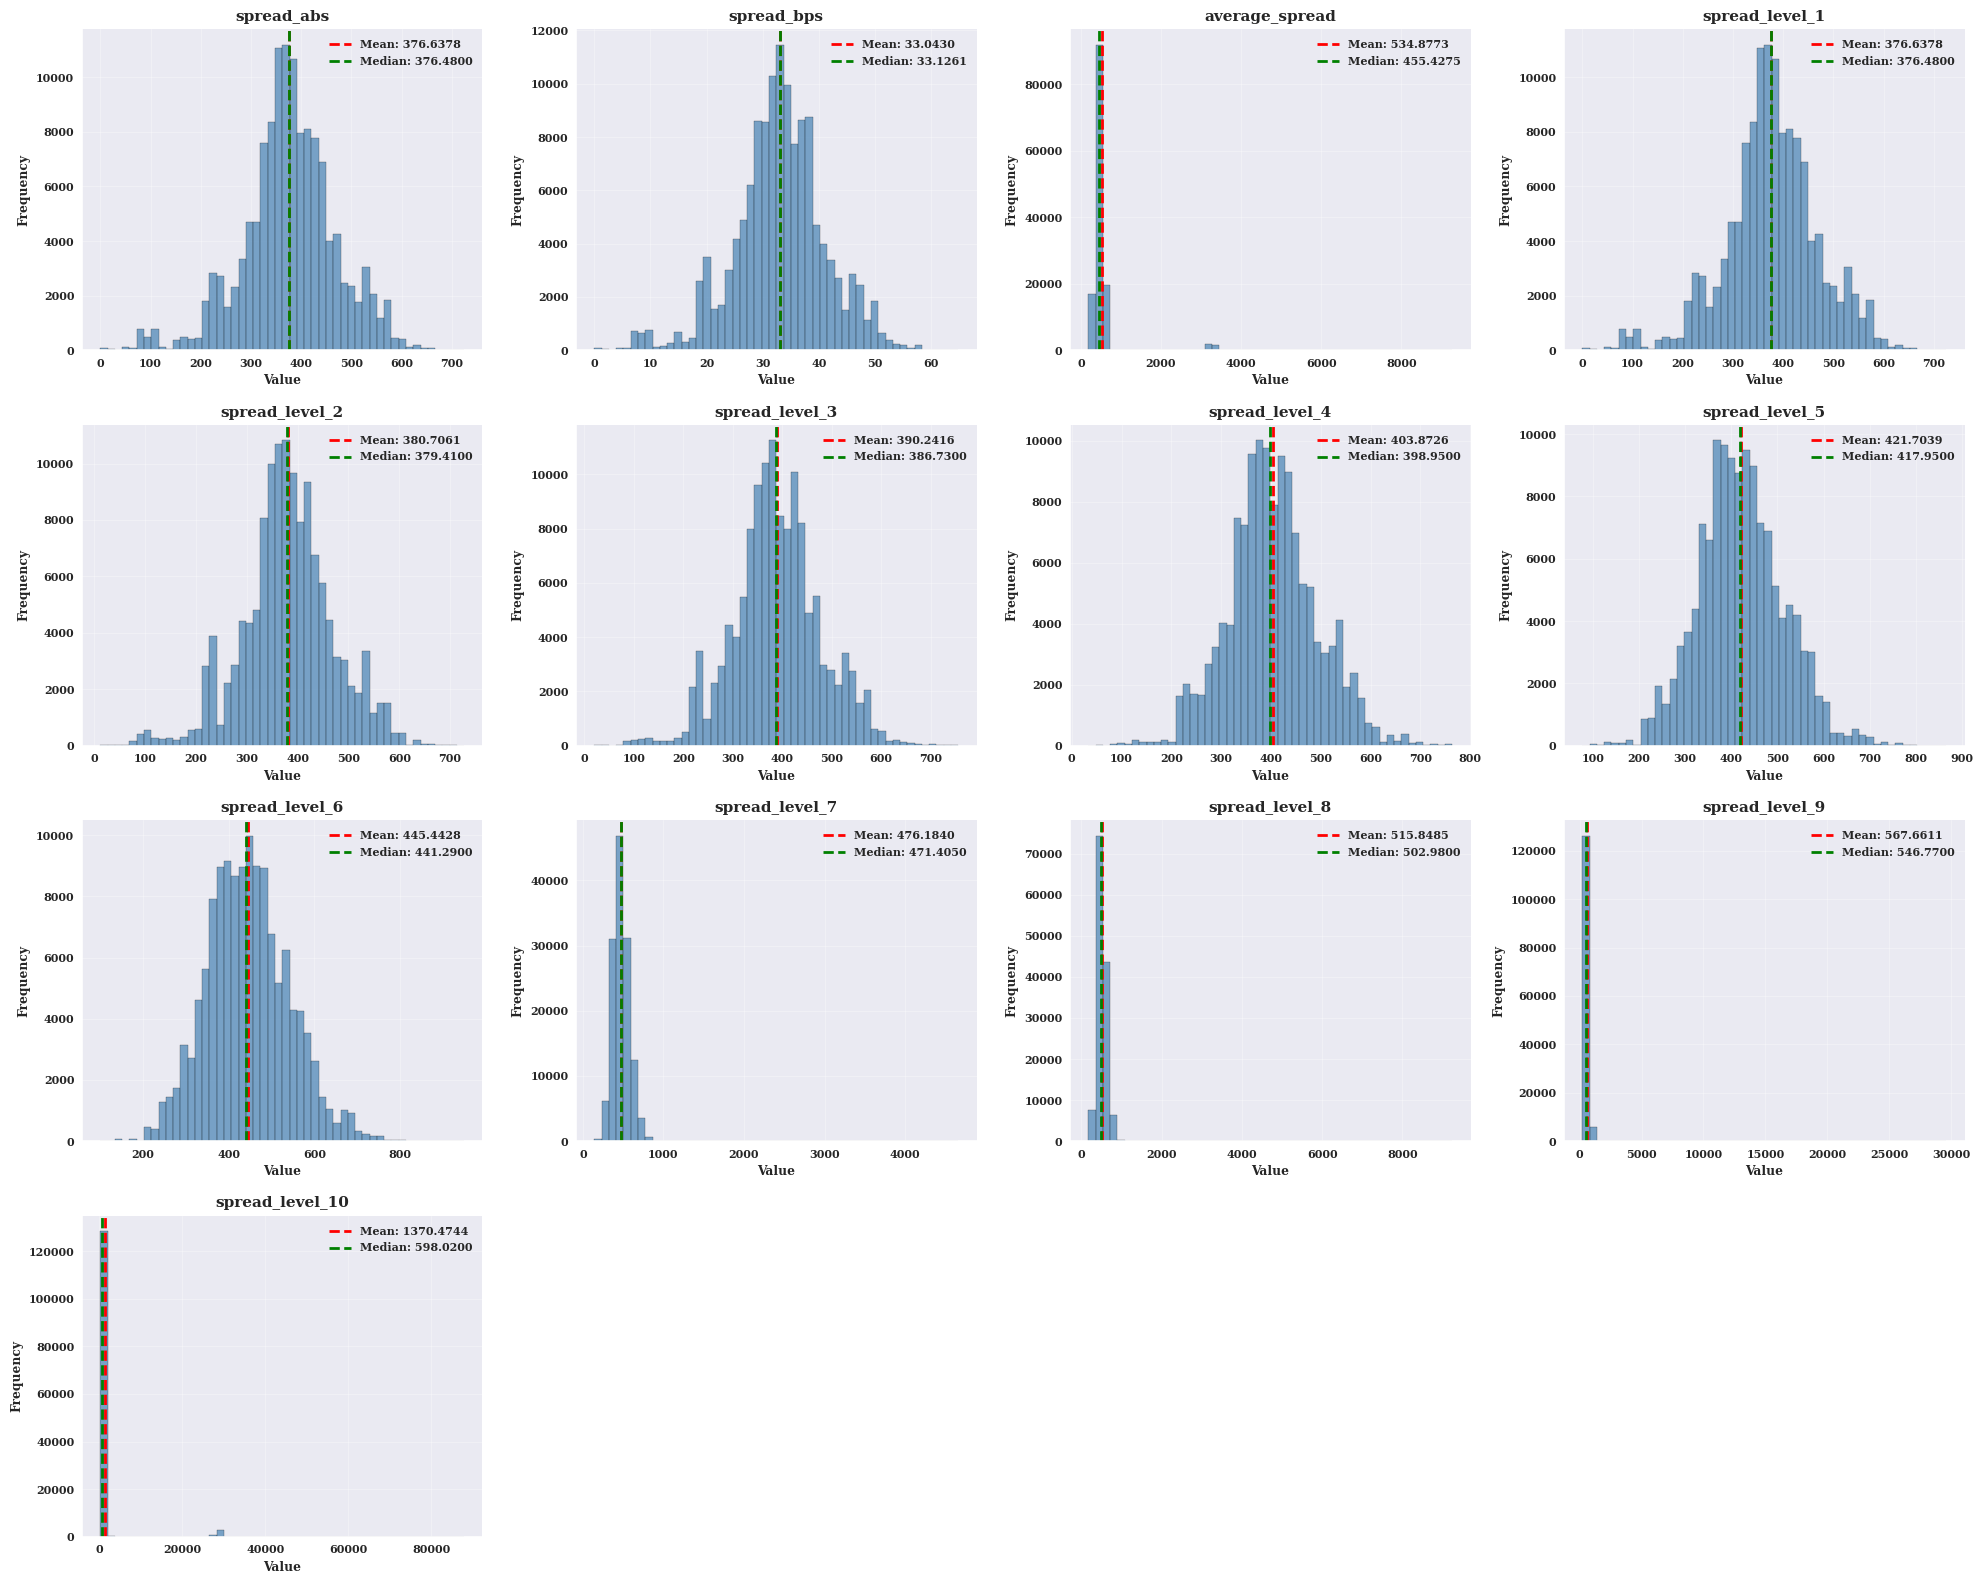

In [11]:
# Create individual visualizations

# Distribution plots
print("\n=== FEATURE DISTRIBUTIONS ===")
feature_groups = get_feature_columns(basic_features)
plot_feature_distributions(
    basic_features, 
    feature_cols=feature_groups['spread'],
    save_path= FIGURES_DIR / 'spread_distributions.png'
)




=== FEATURE GROUP COMPARISON ===
💾 Saved to: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/reports/figures/group_comparison.png


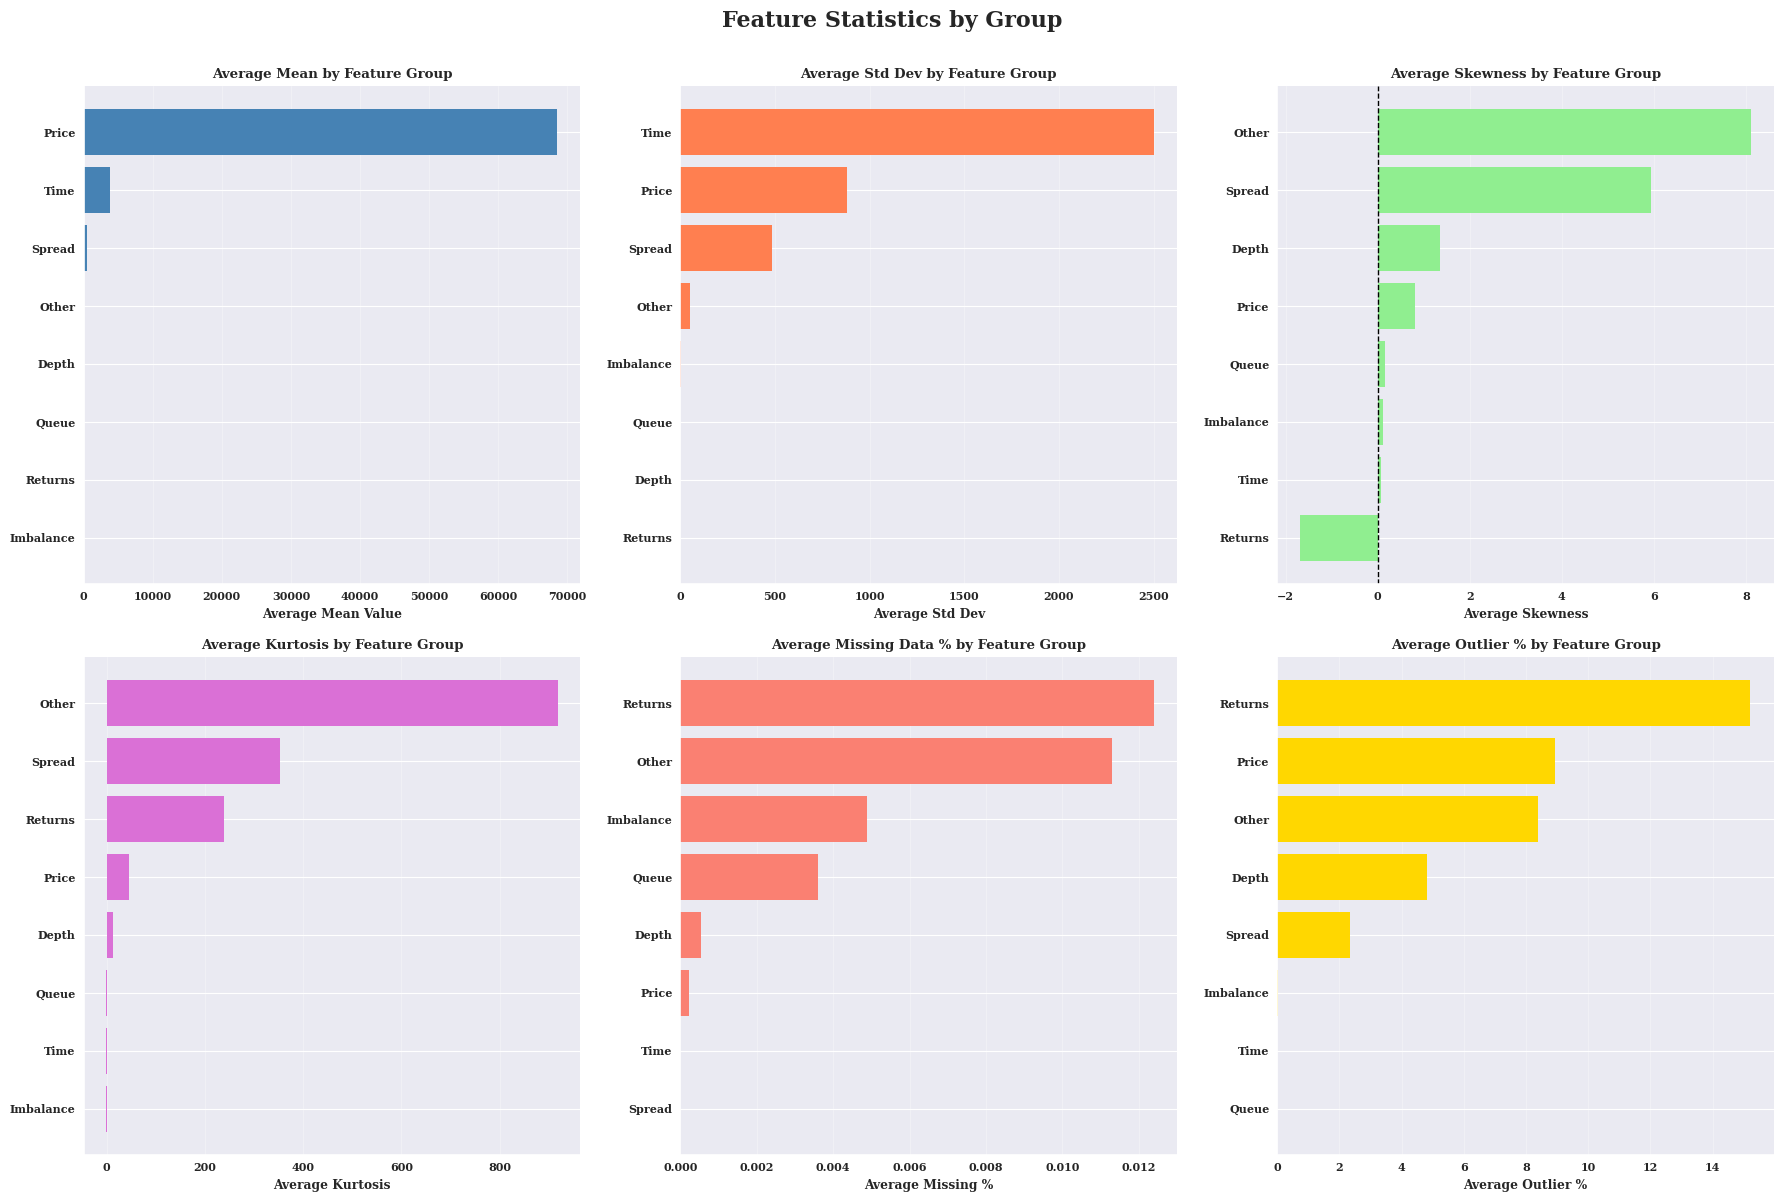

In [12]:
# Feature group comparison
print("\n=== FEATURE GROUP COMPARISON ===")
plot_feature_group_comparison(
    basic_features,
    summary_stats,
    save_path=FIGURES_DIR / 'group_comparison.png'
)




=== TIME SERIES ===
💾 Saved to: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/reports/figures/time_series.png


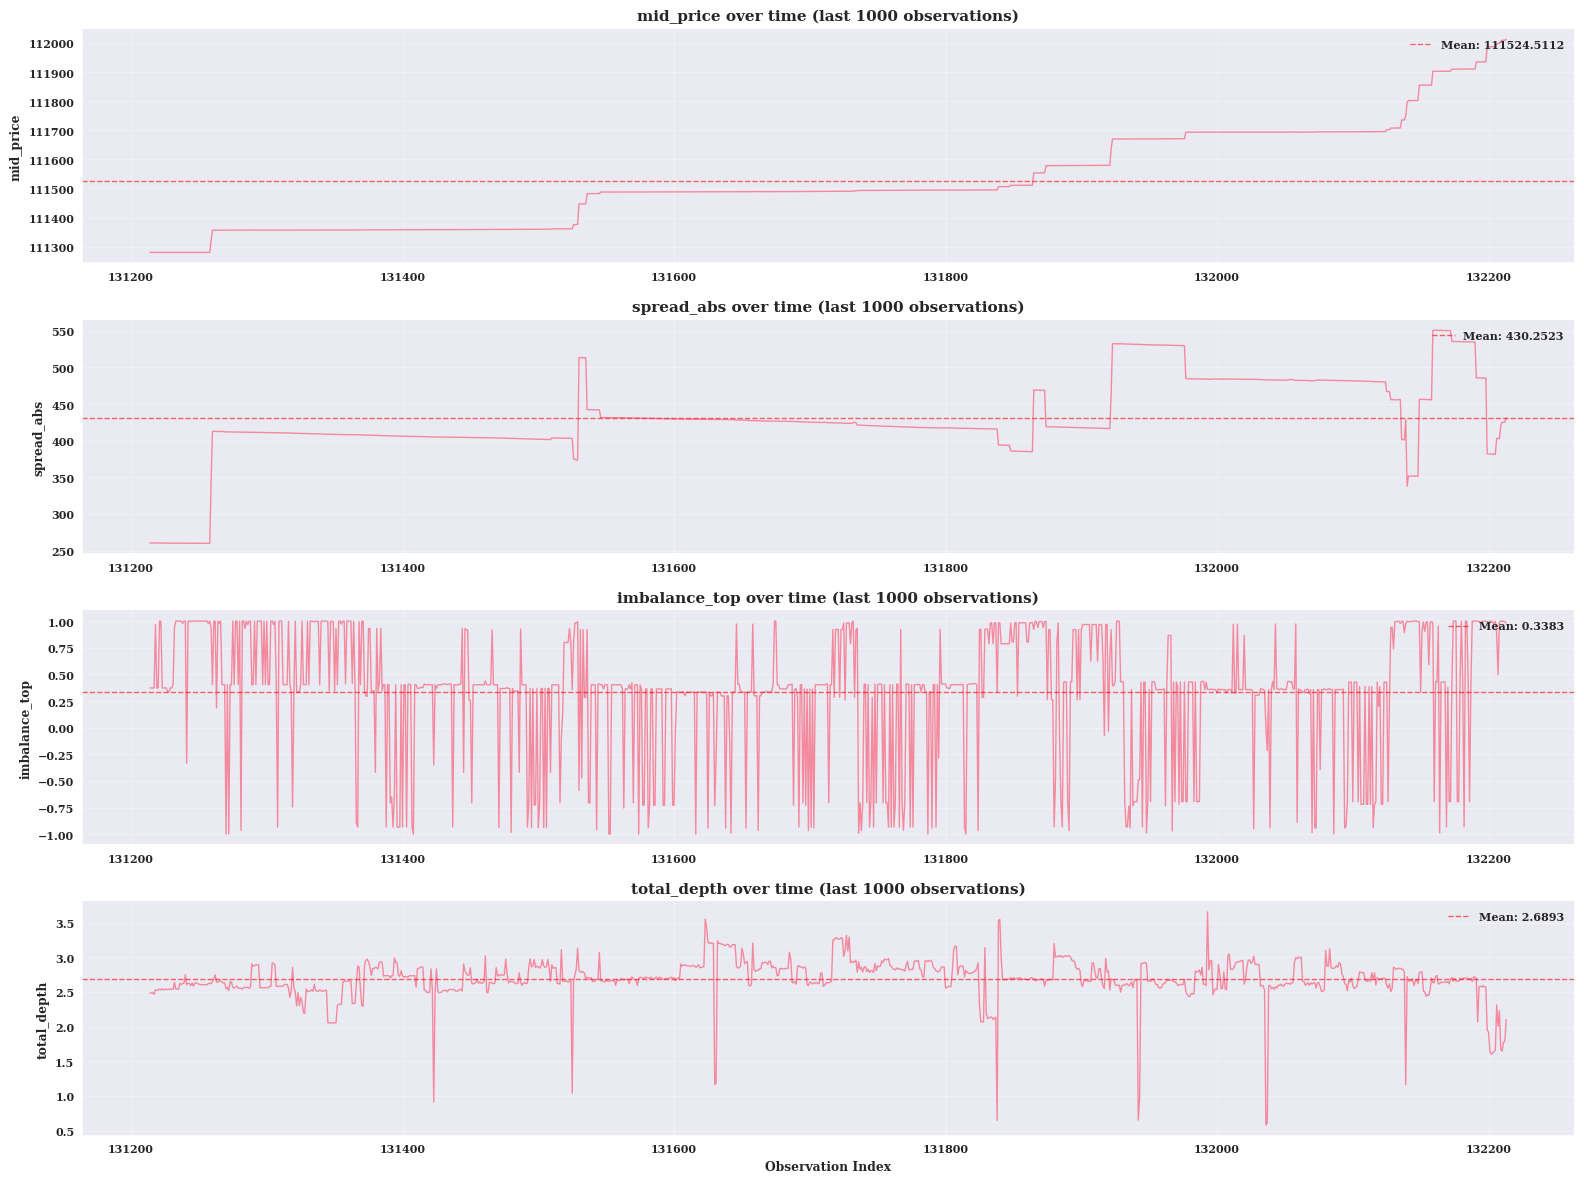

In [13]:
# Time series
print("\n=== TIME SERIES ===")
plot_time_series_features(
    basic_features,
    feature_cols=['mid_price', 'spread_abs', 'imbalance_top', 'total_depth'],
    n_samples=1000,
    save_path=FIGURES_DIR / 'time_series.png'
)




=== FEATURE RELATIONSHIPS ===
💾 Saved to: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/reports/figures/relationships.png


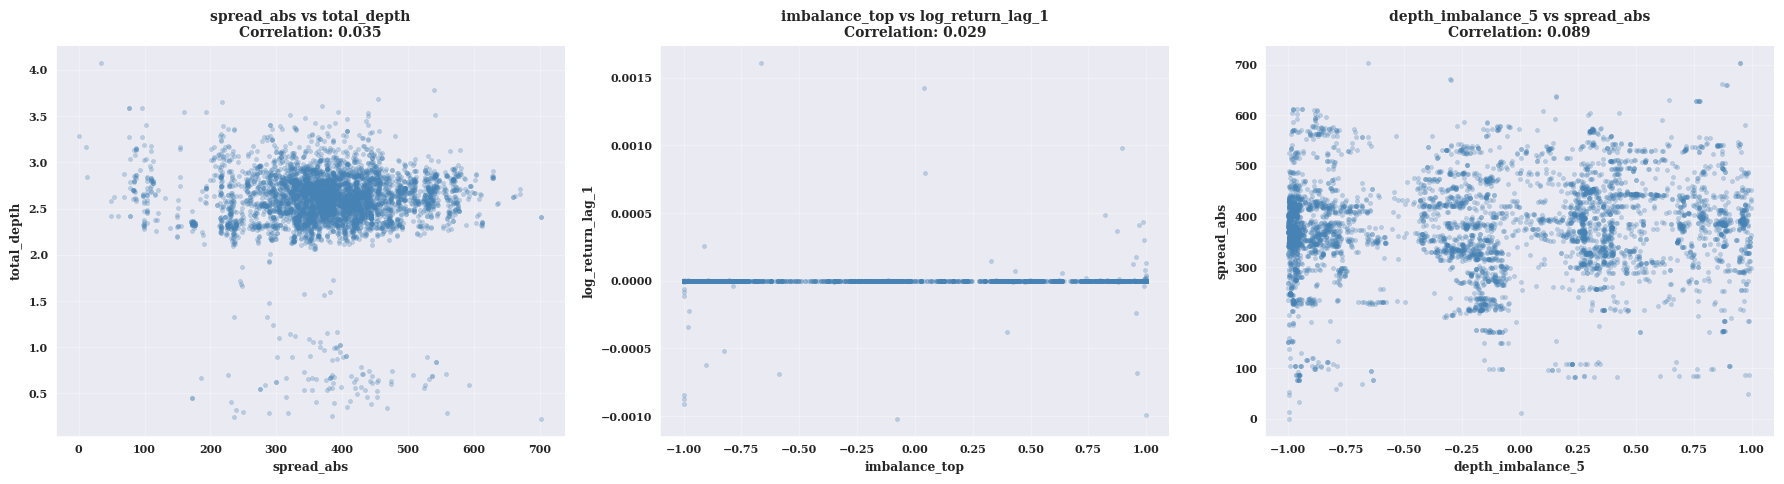

In [14]:
# Relationships
print("\n=== FEATURE RELATIONSHIPS ===")
plot_feature_relationships(
    basic_features,
    feature_pairs=[
        ('spread_abs', 'total_depth'),
        ('imbalance_top', 'log_return_lag_1'),
        ('depth_imbalance_5', 'spread_abs')
    ],
    save_path= FIGURES_DIR / 'relationships.png'
)


=== CORRELATION ANALYSIS ===
💾 Saved to: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/reports/figures/correlation_matrix.png


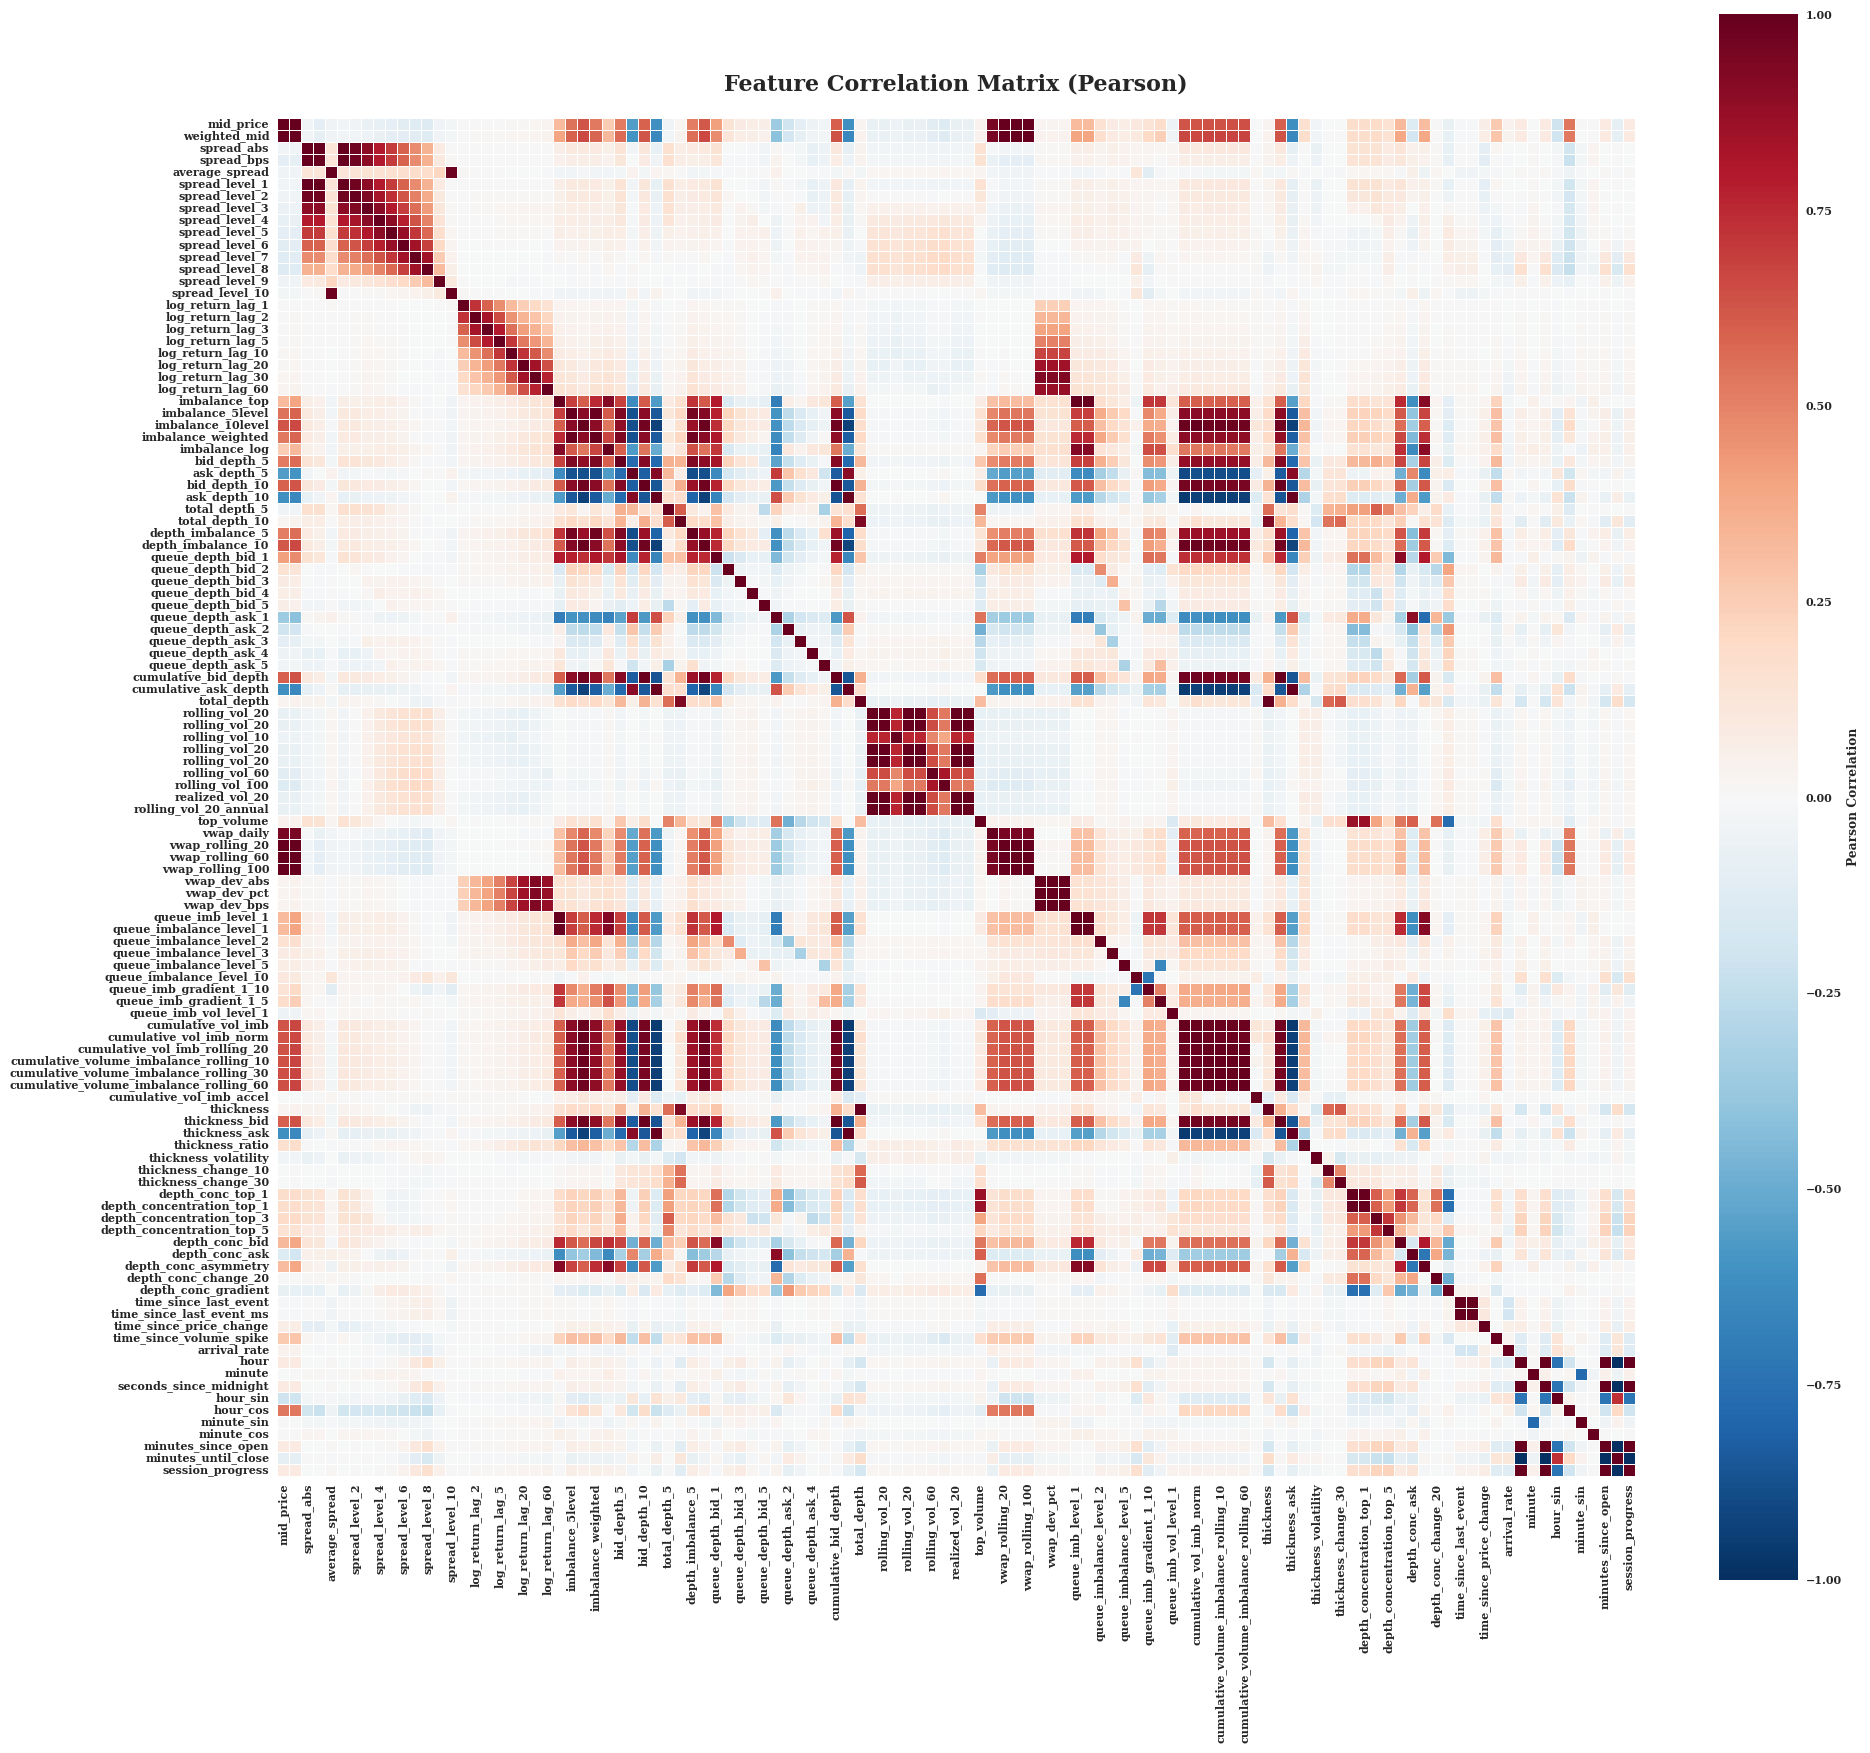

Highly correlated feature pairs (|r| > 0.7):
  mid_price <-> weighted_mid: 0.996
  mid_price <-> vwap_daily: 0.951
  mid_price <-> vwap_rolling_20: 1.000
  mid_price <-> vwap_rolling_60: 1.000
  mid_price <-> vwap_rolling_100: 1.000
  weighted_mid <-> vwap_daily: 0.947
  weighted_mid <-> vwap_rolling_20: 0.996
  weighted_mid <-> vwap_rolling_60: 0.996
  weighted_mid <-> vwap_rolling_100: 0.995
  spread_abs <-> spread_bps: 0.998
  spread_abs <-> spread_level_1: 1.000
  spread_abs <-> spread_level_2: 0.973
  spread_abs <-> spread_level_3: 0.896
  spread_abs <-> spread_level_4: 0.795
  spread_bps <-> spread_level_1: 0.998
  spread_bps <-> spread_level_2: 0.972
  spread_bps <-> spread_level_3: 0.896
  spread_bps <-> spread_level_4: 0.796
  average_spread <-> spread_level_10: 0.984
  spread_level_1 <-> spread_level_2: 0.973
  spread_level_1 <-> spread_level_3: 0.896
  spread_level_1 <-> spread_level_4: 0.795
  spread_level_2 <-> spread_level_3: 0.930
  spread_level_2 <-> spread_level_4: 0.8

In [15]:
# Correlation heatmap
print("\n=== CORRELATION ANALYSIS ===")
corr_matrix = plot_correlation_heatmap(
    basic_features,
    feature_cols=feature_groups['all_engineered'],
    method='pearson',
    save_path= FIGURES_DIR / 'correlation_matrix.png'
)

# Identify highly correlated pairs
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append({
                'feature_1': corr_matrix.columns[i],
                'feature_2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j]
            })

if high_corr_pairs:
    print("Highly correlated feature pairs (|r| > 0.7):")
    for pair in high_corr_pairs:
        print(f"  {pair['feature_1']} <-> {pair['feature_2']}: {pair['correlation']:.3f}")
else:
    print("No highly correlated feature pairs found.")




In [16]:
basic_features.head()

,timestamp,mid_price,weighted_mid,spread_abs,spread_bps,average_spread,spread_level_1,spread_level_2,spread_level_3,spread_level_4,...,seconds_since_midnight,hour_sin,hour_cos,minute_sin,minute_cos,minutes_since_open,minutes_until_close,session_progress,is_market_hours,session_period
0,2025-10-12 22:38:17+00:00,115284.395,115397.228152,496.31,43.050926,582.760,496.31,496.33,496.37,496.42,...,81497,-0.5,0.866025,-0.743145,-0.669131,788.283333,-398.283333,2.021239,False,post_close
1,2025-10-12 22:38:18+00:00,115284.395,115397.228152,496.31,43.050926,582.760,496.31,496.33,496.37,496.42,...,81498,-0.5,0.866025,-0.743145,-0.669131,788.300000,-398.300000,2.021282,False,post_close
2,2025-10-12 22:38:19+00:00,115284.405,115376.588041,496.27,43.047453,543.056,496.27,496.29,496.32,496.35,...,81499,-0.5,0.866025,-0.743145,-0.669131,788.316667,-398.316667,2.021325,False,post_close
3,2025-10-12 22:38:20+00:00,115284.405,115384.232520,496.27,43.047453,558.408,496.27,496.29,496.32,496.38,...,81500,-0.5,0.866025,-0.743145,-0.669131,788.333333,-398.333333,2.021368,False,post_close
4,2025-10-12 22:38:21+00:00,115284.410,115384.231486,496.24,43.044849,558.404,496.24,496.28,496.32,496.38,...,81501,-0.5,0.866025,-0.743145,-0.669131,788.350000,-398.350000,2.021410,False,post_close


## Save Features

In [17]:
# # Save features

print("\n=== Saving Features ===\n")

if 'timestamp' not in basic_features.columns:
    raise ValueError("Need 'timestamp' column to save features")

basic_features = basic_features.loc[:, ~basic_features.columns.duplicated()]

# Select columns to save
output_cols = basic_features.columns.tolist()  # Save all columns

# Save to parquet
basic_features.to_parquet(OUTPUT_FILE, index=False)
print(f"Saved {len(output_cols)} features to {OUTPUT_FILE}")
print(f"File size: {OUTPUT_FILE.stat().st_size / 1024 / 1024:.2f} MB")

# Also save a CSV sample for easy inspection
sample_file = PROCESSED_DATA_DIR / f"{SYMBOL}_basic_features_sample.csv"
basic_features[output_cols].head(1000).to_csv(sample_file, index=False)
print(f"Saved sample (1000 rows) to {sample_file}")

print("\n=== Feature Engineering Complete ===")
print(f"Next step: Run 15_advanced_features.ipynb to compute advanced features.")


=== Saving Features ===

Saved 117 features to /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/data/processed/BTCUSDT_basic_parquet.csv
File size: 77.52 MB
Saved sample (1000 rows) to /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/data/processed/BTCUSDT_basic_features_sample.csv

=== Feature Engineering Complete ===
Next step: Run 15_advanced_features.ipynb to compute advanced features.


____

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.dates import DateFormatter, MinuteLocator
from matplotlib.patches import Rectangle

def create_lob_heatmap_with_features(lob_df, basic_features, 
                                      start_time=None, end_time=None,
                                      save_path='reports/figures/lob_heatmap_with_features.png'):
    """
    Create comprehensive LOB heatmap with feature overlays
    
    Parameters:
    -----------
    lob_df : pd.DataFrame
        Raw LOB data with bid/ask prices and volumes
    basic_features : pd.DataFrame
        Computed features from feature engineering pipeline
    start_time : str or datetime, optional
        Start of time window to plot
    end_time : str or datetime, optional
        End of time window to plot
    save_path : str
        Where to save the figure
    """
    
    # Filter time window if specified
    if start_time is not None and end_time is not None:
        start_time = pd.to_datetime(start_time)
        end_time = pd.to_datetime(end_time)
        
        mask = (basic_features['timestamp'] >= start_time) & (basic_features['timestamp'] <= end_time)
        
        if mask.sum() == 0:
            raise ValueError(f"No data found in time range {start_time} to {end_time}")
        
        lob_df = lob_df[mask].copy()
        basic_features = basic_features[mask].copy()
        
        print(f"Filtered to {len(basic_features)} rows between {start_time} and {end_time}")
    
    # Check for minimum data
    if len(basic_features) == 0:
        raise ValueError("basic_features is empty after filtering")
    
    # Limit to manageable time window (e.g., 15-30 minutes for visualization)
    if len(basic_features) > 1800:  # More than 30 min at 1 event/sec
        print(f"Data has {len(basic_features)} points. Showing first 1800 (30 minutes)...")
        lob_df = lob_df.iloc[:1800]
        basic_features = basic_features.iloc[:1800]
    
    timestamps = basic_features['timestamp'].values
    mid_prices = basic_features['mid_price'].values
    
    # Extract LOB depth matrix (10 levels)
    n_levels = 10
    
    # Check if LOB columns exist
    required_lob_cols = [f'bid_price_{i}' for i in range(1, n_levels+1)] + \
                        [f'ask_price_{i}' for i in range(1, n_levels+1)] + \
                        [f'bid_volume_{i}' for i in range(1, n_levels+1)] + \
                        [f'ask_volume_{i}' for i in range(1, n_levels+1)]
    
    missing_lob_cols = [col for col in required_lob_cols if col not in lob_df.columns]
    if missing_lob_cols:
        raise ValueError(f"Missing LOB columns: {missing_lob_cols[:5]}... (showing first 5)")
    
    bid_prices = lob_df[[f'bid_price_{i}' for i in range(1, n_levels+1)]].values
    ask_prices = lob_df[[f'ask_price_{i}' for i in range(1, n_levels+1)]].values
    bid_volumes = lob_df[[f'bid_volume_{i}' for i in range(1, n_levels+1)]].values
    ask_volumes = lob_df[[f'ask_volume_{i}' for i in range(1, n_levels+1)]].values
    
    # Check for valid data
    if bid_prices.size == 0 or ask_prices.size == 0:
        raise ValueError("No valid LOB price data found")
    
    # Create figure with 5 panels
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(5, 1, height_ratios=[3, 1, 1, 1, 1], hspace=0.3)
    
    axes = [fig.add_subplot(gs[i, 0]) for i in range(5)]
    
    # =============================================================================
    # PANEL 1: LOB DEPTH HEATMAP
    # =============================================================================
    ax1 = axes[0]
    
    # Create price grid for heatmap
    # Stack bid and ask prices/volumes
    all_prices = np.concatenate([bid_prices, ask_prices], axis=1)
    all_volumes = np.concatenate([bid_volumes, ask_volumes], axis=1)
    
    # Remove NaN values for min/max calculation
    valid_prices = all_prices[~np.isnan(all_prices)]
    
    if len(valid_prices) == 0:
        raise ValueError("All price values are NaN - cannot create heatmap")
    
    # Create uniform price grid
    price_min = np.nanmin(valid_prices)
    price_max = np.nanmax(valid_prices)
    
    if price_min == price_max:
        # Add small buffer if prices don't vary
        price_min -= 0.01 * price_min
        price_max += 0.01 * price_max
    
    price_bins = np.linspace(price_min, price_max, 50)
    
    # Create volume matrix for heatmap
    volume_matrix = np.zeros((len(price_bins)-1, len(timestamps)))
    
    for t_idx in range(len(timestamps)):
        # Bid side
        for level in range(n_levels):
            price = bid_prices[t_idx, level]
            volume = bid_volumes[t_idx, level]
            if not np.isnan(price) and not np.isnan(volume) and volume > 0:
                price_idx = np.digitize(price, price_bins) - 1
                if 0 <= price_idx < len(price_bins)-1:
                    volume_matrix[price_idx, t_idx] += volume
        
        # Ask side
        for level in range(n_levels):
            price = ask_prices[t_idx, level]
            volume = ask_volumes[t_idx, level]
            if not np.isnan(price) and not np.isnan(volume) and volume > 0:
                price_idx = np.digitize(price, price_bins) - 1
                if 0 <= price_idx < len(price_bins)-1:
                    volume_matrix[price_idx, t_idx] += volume
    
    # Plot heatmap
    extent = [0, len(timestamps), price_bins[0], price_bins[-1]]
    im = ax1.imshow(volume_matrix, aspect='auto', origin='lower', 
                     extent=extent, cmap='YlOrRd', interpolation='nearest',
                     alpha=0.8)
    
    # Overlay mid-price line
    time_indices = np.arange(len(timestamps))
    ax1.plot(time_indices, mid_prices, color='white', linewidth=2.5, 
             label='Mid Price', zorder=10, linestyle='-', alpha=0.9)
    ax1.plot(time_indices, mid_prices, color='black', linewidth=1.5, 
             label='_nolegend_', zorder=9, linestyle='-', alpha=0.7)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax1, orientation='vertical', pad=0.01)
    cbar.set_label('Volume', rotation=270, labelpad=20, fontsize=10)
    
    ax1.set_ylabel('Price Level', fontsize=11, fontweight='bold')
    ax1.set_title('Limit Order Book Depth Evolution', fontsize=13, fontweight='bold', pad=10)
    ax1.legend(loc='upper left', fontsize=9, framealpha=0.9)
    ax1.grid(True, alpha=0.2, linestyle='--')
    ax1.set_xticks([])
    
    # =============================================================================
    # PANEL 2: ORDER FLOW IMBALANCE
    # =============================================================================
    ax2 = axes[1]
    
    imbalance = basic_features['imbalance_top'].values.flatten()
    
    ax2.fill_between(time_indices, 0, imbalance, 
                      where=(imbalance >= 0), 
                      color='green', alpha=0.4, label='Bid Pressure',
                      interpolate=True)
    ax2.fill_between(time_indices, 0, imbalance, 
                      where=(imbalance < 0), 
                      color='red', alpha=0.4, label='Ask Pressure',
                      interpolate=True)
    ax2.plot(time_indices, imbalance, color='black', linewidth=1.2, alpha=0.7)
    ax2.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.6)
    
    ax2.set_ylabel('Imbalance', fontsize=10, fontweight='bold')
    ax2.set_ylim(-1, 1)
    ax2.legend(loc='upper left', fontsize=8, framealpha=0.9)
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.set_xticks([])
    
    # =============================================================================
    # PANEL 3: BID-ASK SPREAD
    # =============================================================================
    ax3 = axes[2]
    
    spread_bps = basic_features['spread_bps'].values.flatten()
    
    ax3.plot(time_indices, spread_bps, color='purple', linewidth=1.5, alpha=0.8)
    ax3.fill_between(time_indices, 0, spread_bps, alpha=0.2, color='purple')
    
    mean_spread = np.nanmean(spread_bps)
    ax3.axhline(mean_spread, color='purple', linestyle='--', 
                linewidth=1, alpha=0.5, label=f'Mean: {mean_spread:.1f} bps')
    
    ax3.set_ylabel('Spread (bps)', fontsize=10, fontweight='bold')
    ax3.legend(loc='upper right', fontsize=8, framealpha=0.9)
    ax3.grid(True, alpha=0.3, linestyle='--')
    ax3.set_xticks([])
    
    # =============================================================================
    # PANEL 4: VOLATILITY (ROLLING)
    # =============================================================================
    ax4 = axes[3]
    
    volatility = basic_features['rolling_vol_20'].values.flatten() * 10000
    
    ax4.plot(time_indices, volatility, color='orange', linewidth=1.5, alpha=0.8,
             label='Rolling Vol (20-period)')
    ax4.fill_between(time_indices, 0, volatility, alpha=0.2, color='orange')
    
    mean_vol = np.nanmean(volatility)
    ax4.axhline(mean_vol, color='orange', linestyle='--', 
                linewidth=1, alpha=0.5, label=f'Mean: {mean_vol:.2f}')
    
    ax4.set_ylabel('Volatility\n(×10⁴)', fontsize=10, fontweight='bold')
    ax4.legend(loc='upper right', fontsize=8, framealpha=0.9)
    ax4.grid(True, alpha=0.3, linestyle='--')
    ax4.set_xticks([])
    
    # =============================================================================
    # PANEL 5: DEPTH CONCENTRATION
    # =============================================================================
    ax5 = axes[4]
    
    depth_conc = basic_features['depth_concentration_top_1'].values.flatten()
    
    ax5.plot(time_indices, depth_conc, color='teal', linewidth=1.5, alpha=0.8,
             label='Top-of-Book Concentration')
    ax5.fill_between(time_indices, 0, depth_conc, alpha=0.2, color='teal')
    
    mean_conc = np.nanmean(depth_conc)
    ax5.axhline(mean_conc, color='teal', linestyle='--', 
                linewidth=1, alpha=0.5, label=f'Mean: {mean_conc:.2f}')
    
    ax5.set_ylabel('Depth\nConcentration', fontsize=10, fontweight='bold')
    ax5.set_xlabel('Time Index', fontsize=11, fontweight='bold')
    ax5.legend(loc='upper right', fontsize=8, framealpha=0.9)
    ax5.grid(True, alpha=0.3, linestyle='--')
    
    # Format x-axis with actual times
    if len(timestamps) < 100:
        xtick_positions = time_indices[::max(1, len(time_indices)//10)]
    else:
        xtick_positions = time_indices[::len(time_indices)//10]
    
    xtick_labels = [pd.Timestamp(timestamps[int(i)]).strftime('%H:%M:%S') 
                    for i in xtick_positions if i < len(timestamps)]
    ax5.set_xticks(xtick_positions[:len(xtick_labels)])
    ax5.set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=8)
    
    fig.suptitle('Limit Order Book Dynamics with Microstructure Features', 
                 fontsize=15, fontweight='bold', y=0.995)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"\n✓ Saved LOB heatmap to: {save_path}")
    
    return fig, axes

In [51]:
list(basic_features.columns)

['timestamp',
 'mid_price',
 'weighted_mid',
 'spread_abs',
 'spread_bps',
 'average_spread',
 'spread_level_1',
 'spread_level_2',
 'spread_level_3',
 'spread_level_4',
 'spread_level_5',
 'spread_level_6',
 'spread_level_7',
 'spread_level_8',
 'spread_level_9',
 'spread_level_10',
 'log_return_lag_1',
 'log_return_lag_2',
 'log_return_lag_3',
 'log_return_lag_5',
 'log_return_lag_10',
 'log_return_lag_20',
 'log_return_lag_30',
 'log_return_lag_60',
 'imbalance_top',
 'imbalance_5level',
 'imbalance_10level',
 'imbalance_weighted',
 'imbalance_log',
 'bid_depth_5',
 'ask_depth_5',
 'bid_depth_10',
 'ask_depth_10',
 'total_depth_5',
 'total_depth_10',
 'depth_imbalance_5',
 'depth_imbalance_10',
 'avg_bid_volume_5',
 'avg_ask_volume_5',
 'avg_bid_volume_10',
 'avg_ask_volume_10',
 'queue_depth_bid_1',
 'queue_depth_bid_2',
 'queue_depth_bid_3',
 'queue_depth_bid_4',
 'queue_depth_bid_5',
 'queue_depth_ask_1',
 'queue_depth_ask_2',
 'queue_depth_ask_3',
 'queue_depth_ask_4',
 'queue_d

Data has 1801 points. Showing first 1800 (30 minutes)...

✓ Saved LOB heatmap to: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/reports/figures/lob_heatmap.png


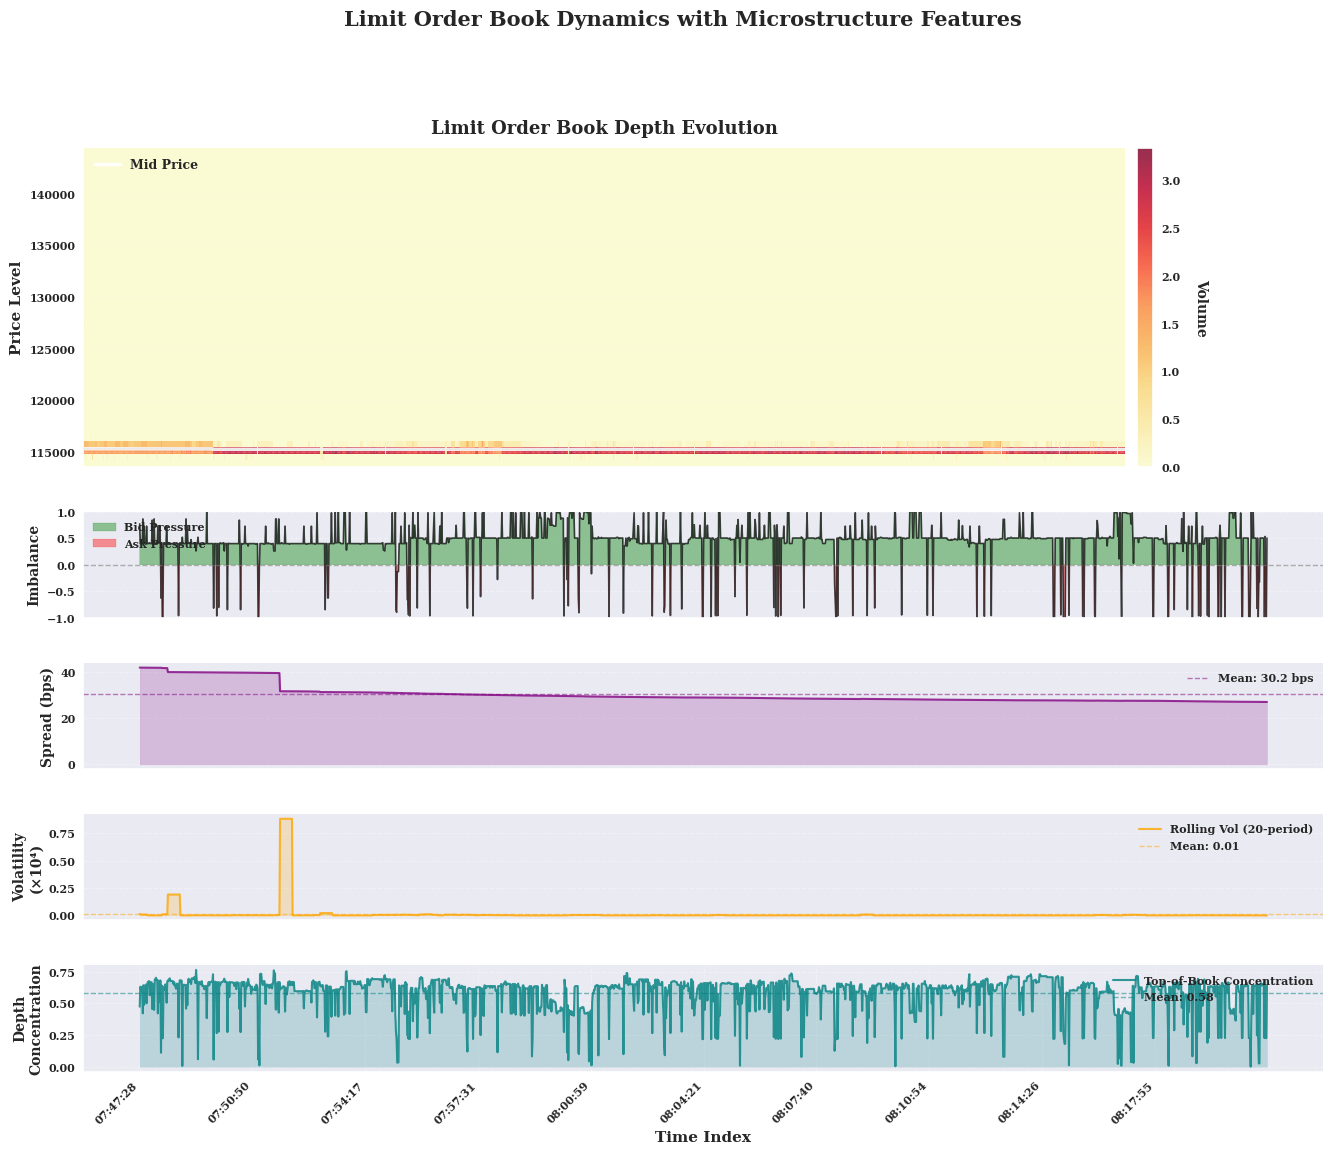

In [47]:
fig, axes = create_lob_heatmap_with_features(
    lob_df=lob_df,
    basic_features=basic_features,
    start_time=basic_features['timestamp'].iloc[30000],
    end_time=basic_features['timestamp'].iloc[30000 + 1800],
    save_path=FIGURES_DIR / 'lob_heatmap.png'
)

In [ ]:

# Example 2: With trade events (if trade data available)
# fig, axes = create_lob_heatmap_with_trades(
#     lob_df=lob_df,
#     basic_features=basic_features,
#     trade_df=trade_df,  # Your trade data
#     start_time='2024-01-15 10:00:00',
#     end_time='2024-01-15 10:15:00',
#     save_path='reports/figures/lob_heatmap_with_trades.png'
# )

In [44]:
basic_features['timestamp'].iloc[0], basic_features['timestamp'].iloc[-1],

(Timestamp('2025-10-12 22:38:17+0000', tz='UTC'),
 Timestamp('2025-10-14 15:43:45+0000', tz='UTC'))